In [ ]:
# -*- coding: utf-8 -*-
# @Time : 2023-12-12 21:34:09
# @Author : Quanta
# @Email : panquantc@gmail.com

# 前一节我们描述了过拟合的问题，本节我们将介绍一些正则化模型的技术。 
# 用于对抗过拟合的技术称为正则化（regularization）

# 在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。


In [ ]:
# 我们总是可以通过去收集更多的训练数据来缓解过拟合。 但这可能成本很高，耗时颇多，或者完全超出我们的控制，因而在短期内不可能做到。
# 1. 限制特征的数量: 通过调整拟合多项式的阶数来限制模型的容量, but 简单地丢弃特征对这项工作来说可能过于生硬。
# 2. 权重衰减: 常也被称为L2正则化, 是最广泛使用的正则化的技术之一,最常用方法是将其范数作为惩罚项加到最小化损失的问题中

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
# 首先，我们像以前一样生成一些数据

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [4]:
# 下面我们将从头开始实现权重衰减，只需将L2的平方惩罚添加到原始目标函数中。

# 定义一个函数来随机初始化模型参数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# 定义L2的平方惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

# 定义训练代码实现
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.24765396118164


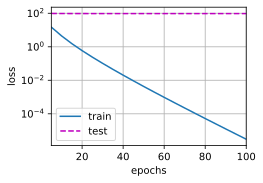

In [5]:
# 忽略正则化直接训练

train(lambd=0)

w的L2范数是： 0.3855628967285156


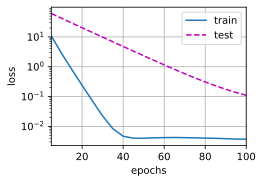

In [6]:
# 使用权重衰减

train(lambd=3)

In [7]:
# a concise code
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 14.83105754852295


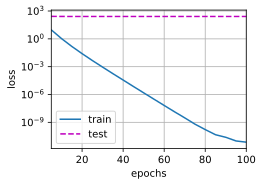

In [8]:
train_concise(0)

w的L2范数： 0.38239866495132446


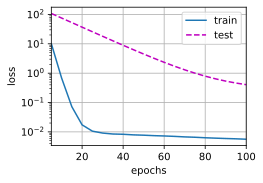

In [9]:
train_concise(3)